# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is on thing or another (there can be multiple things as the options).

Book version of this notebook: https://www.learnpytorch.io/02_pytorch_classification/

All other resources - https://github.com/mrdbourke/pytorch-deep-learning

## 1. Make classification data and get it ready

In [1]:
import sklearn


In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)


In [3]:
len(X), len(y)


(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")


First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [5]:
# Make DataFrame or circle data
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)


,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


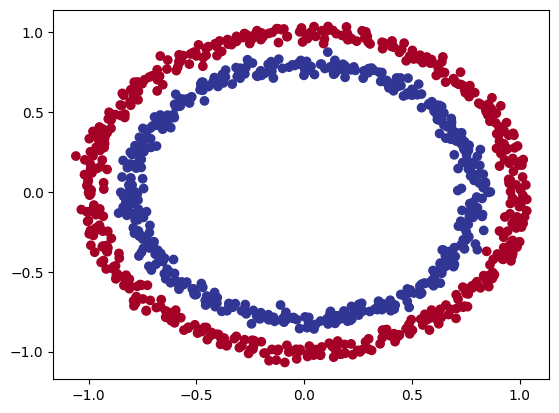

In [6]:
# Visualize, Visualize,Visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)


**Note:** The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizable enough to practice the fundamentals

### 1.1 Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [9]:
import torch

torch.__version__

'1.12.1+cpu'

In [10]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [12]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify out blue and red dots.

To do so, we want to:
1. Setup device agnostic code so out code will run on an acceleratior (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop


In [14]:
import torch
from torch import nn

# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we've setup device agnostic code, let's create a model that:

1. Subclass `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outline the forward pass (or forward computation ) of the model
4. Instantiate an instance of our model class and send it to the target `device`

In [15]:
# 1. Construct a model that sublclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5)  # takes in 2 features and upscales to 5 features
        self.layer_2 = nn.Linear(in_features=5,
                                  out_features=1)  # takes in 5 features from the previous layer and outputs a single feature (same shape as y)

    # 3. Define a forward() method that outlines the forward path
    def forward(self, x):
        return self.layer_2(self.layer_1(x))  # x-> layer_1 -> layer_2 -> output


# 4. Instantiate an instance of our model class and send it to the target device

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
next(model_0.parameters()).device

device(type='cpu')

In [17]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.4557,  0.1076],
                      [-0.1456,  0.0746],
                      [-0.1176, -0.5469],
                      [ 0.0051,  0.5290],
                      [-0.1020,  0.3390]])),
             ('0.bias', tensor([ 0.1095, -0.1670,  0.5196,  0.3776, -0.5713])),
             ('1.weight',
              tensor([[ 0.3453, -0.3539,  0.0234,  0.2670,  0.2770]])),
             ('1.bias', tensor([-0.4089]))])

In [23]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n {torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels: \n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
 tensor([[-0.],
        [-0.],
        [-0.],
        [-0.],
        [-1.],
        [-1.],
        [-0.],
        [-0.],
        [-0.],
        [-0.]])

First 10 labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [22]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup Loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.

For example for regression you might want MAE or MSE (mean absolute error or mean squared error)

For classification you might want binary cross entropy  or categorical cross entropy (cross entropy).